<a href="https://colab.research.google.com/github/victorm0202/temas_selectos_DL/blob/main/s2s_attention_character_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to sequence con atención a nivel caracteres.

## Adaptado de https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html

In [ ]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

#sys.path.append(os.path.abspath(os.path.join('..')))


INPUT_LENGTH = 20
OUTPUT_LENGTH = 20


Usamos un corpus paralelo inglés-español

In [ ]:
import pandas as pd
data = pd.read_table('spa.txt', header=None)
data

,0,1
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
118959,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118960,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118961,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118962,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...


# Data pre-processing

In [ ]:
c = data.columns
data[[c[0], c[1]]] = data[[c[1], c[0]]]
data = data.sample(frac=1, random_state=0)

data_input = [s.lower() for s in data[0]]
data_output = [s.lower() for s in data[1]]

print(data_input[0:3])
print(data_output[0:3])

['ella adora los gatos.', 'tom vio a mary irse.', 'te has puesto tan alto.']
['she adores cats.', 'tom saw mary leave.', "you've grown so tall."]


In [ ]:
data_size = len(data)

training_split_index = int(data_size*60/100)
validation_split_index = int(data_size*70/100)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[:training_split_index]
training_output = data_output[:training_split_index]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[training_split_index:validation_split_index]
validation_output = data_output[training_split_index:validation_split_index]

print(len(training_input))
print(len(validation_input))

71378
11896


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.


In [ ]:
START_CHAR_CODE = 1

def encode_characters(titles):
    count = 2
    encoding = {}
    decoding = {1: 'START'}
    for c in set([c for title in titles for c in title]):
        encoding[c] = count
        decoding[count] = c
        count += 1
    return encoding, decoding, count


input_encoding, input_decoding, input_dict_size = encode_characters(data_input)
output_encoding, output_decoding, output_dict_size = encode_characters(data_output)


print('input character dict size:', input_dict_size)
print('output character dict size:', output_dict_size)

print(list(input_encoding.items())[0:55])
print(list(output_encoding.items())[0:15])

input character dict size: 82
output character dict size: 66
[('ü', 2), ('q', 3), ('8', 4), ('s', 5), ('"', 6), ('á', 7), ('k', 8), ('ś', 9), ('y', 10), ('&', 11), ('í', 12), ('«', 13), ('d', 14), (';', 15), ('ö', 16), (',', 17), ('u', 18), ('¨', 19), ('.', 20), ('f', 21), ('ª', 22), ('3', 23), ('ñ', 24), ('¡', 25), ('—', 26), ('é', 27), ('å', 28), ('+', 29), ('l', 30), ('w', 31), ('7', 32), ('i', 33), ('с', 34), ('è', 35), ('6', 36), ('č', 37), ('n', 38), ('¿', 39), (')', 40), ('0', 41), ('v', 42), ('t', 43), ('b', 44), ('(', 45), ('h', 46), ('m', 47), ('g', 48), ('-', 49), ('c', 50), ("'", 51), ('2', 52), ('\u200b', 53), ('5', 54), ('?', 55), ('$', 56)]
[('h', 2), ('’', 3), ('3', 4), ('ü', 5), ('q', 6), ('8', 7), ('s', 8), (':', 9), ('m', 10), ('₂', 11), ('"', 12), ('j', 13), ('é', 14), ('ê', 15), ('+', 16)]


In [ ]:
def transform(encoding, data, vector_size):
    transformed_data = np.zeros(shape=(len(data), vector_size), dtype='int')
    for i in range(len(data)):
        for j in range(min(len(data[i]), vector_size)):
            transformed_data[i][j] = encoding[data[i][j]]
    return transformed_data

INPUT_LENGTH = 20
OUTPUT_LENGTH = 20

encoded_training_input = transform(input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = transform(output_encoding, training_output, vector_size=OUTPUT_LENGTH)
encoded_validation_input = transform(input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = transform(output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('input', encoded_training_input)
print('output', encoded_training_output)

input [[60 30 30 ... 43 72  5]
 [43 72 47 ...  5 60 20]
 [43 60 58 ... 58 59 30]
 ...
 [43 60 38 ... 43 59 14]
 [50 70 60 ... 18 60 38]
 [43 72 47 ... 46 60 70]]
output [[ 8  2 59 ...  0  0  0]
 [47 38 10 ... 59 58  0]
 [30 38 51 ... 56 17 17]
 ...
 [23 55  2 ... 10 55 22]
 [23 55 47 ... 55 18 38]
 [47 38 10 ... 38 20 59]]


# Sequence-to-Sequence in Keras

In [ ]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder

In [ ]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_2/Identity:0", shape=(None, 20, 64), dtype=float32)
encoder_last Tensor("strided_slice_1:0", shape=(None, 64), dtype=float32)
decoder Tensor("lstm_3/Identity:0", shape=(None, 20, 64), dtype=float32)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [ ]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)


attention Tensor("attention_1/Identity:0", shape=(None, 20, 20), dtype=float32)
context Tensor("dot_3/Identity:0", shape=(None, 20, 64), dtype=float32)
decoder_combined_context Tensor("concatenate_1/Identity:0", shape=(None, 20, 128), dtype=float32)
output Tensor("time_distributed_3/Identity:0", shape=(None, 20, 66), dtype=float32)


In [ ]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 64)       5248        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 20, 64)       33024       embedding_2[0][0]                
____________________________________________________________________________________________

## Training the model

In [ ]:
# Encoder Input
training_encoder_input = encoded_training_input

# Decoder Input (need padding py START_CHAR_CODE)
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = START_CHAR_CODE
# Decoder Output (one-hot encode)
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = START_CHAR_CODE
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [ ]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30)

model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=50)

model.save('model.h5')

Epoch 1/50
1116/1116 - 20s - loss: 0.9055 - val_loss: 0.9423
Epoch 2/50
1116/1116 - 19s - loss: 0.9026 - val_loss: 0.9421
Epoch 3/50
1116/1116 - 19s - loss: 0.9004 - val_loss: 0.9389
Epoch 4/50
1116/1116 - 19s - loss: 0.8978 - val_loss: 0.9387
Epoch 5/50
1116/1116 - 20s - loss: 0.8952 - val_loss: 0.9361
Epoch 6/50
1116/1116 - 20s - loss: 0.8927 - val_loss: 0.9350
Epoch 7/50
1116/1116 - 20s - loss: 0.8902 - val_loss: 0.9306
Epoch 8/50
1116/1116 - 20s - loss: 0.8882 - val_loss: 0.9305
Epoch 9/50
1116/1116 - 21s - loss: 0.8861 - val_loss: 0.9269
Epoch 10/50
1116/1116 - 20s - loss: 0.8839 - val_loss: 0.9273
Epoch 11/50
1116/1116 - 20s - loss: 0.8819 - val_loss: 0.9259
Epoch 12/50
1116/1116 - 20s - loss: 0.8799 - val_loss: 0.9266
Epoch 13/50
1116/1116 - 20s - loss: 0.8776 - val_loss: 0.9217
Epoch 14/50
1116/1116 - 20s - loss: 0.8756 - val_loss: 0.9183
Epoch 15/50
1116/1116 - 20s - loss: 0.8740 - val_loss: 0.9201
Epoch 16/50
1116/1116 - 20s - loss: 0.8723 - val_loss: 0.9163
Epoch 17/50
1116/

### Testing the model


In [ ]:
def generate(text):
    encoder_input = transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = START_CHAR_CODE
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[0, 1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += decoding[i]
    return text

def to_english(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output)

In [ ]:
to_english('vamos a la escuela')

"let's go to the sam"

# Visualize Attention

## OJO: solo lo pongo como referencia, ya que al ser la traducción a nivel de caracteres, no tiene tanto sentido como cuando es a nivel de palabras (ver el otro notebook)

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [ ]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[8] == model.get_layer('attention'))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd2f810f430>	name:input_3
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fd2f810fc10>	name:embedding_2
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd2f810f100>	name:input_4
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fd2f810f040>	name:lstm_2
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fd2f906e250>	name:embedding_3
<tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7fd2f906ef40>	name:tf_op_layer_strided_slice_1
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fd2f906e6a0>	name:lstm_3
<tensorflow.python.keras.layers.merge.Dot object at 0x7fd2f905cdc0>	name:dot_2
<tensorflow.python.keras.layers.core.Activation object at 0x7fd2f90521f0>	name:attention
<tensorflow.python.keras.layers.merge.Dot object at 0x7fd2f9052e80>	name:dot_3
<tensorflow.python.keras.layers.merge.Concatenate object at 0x7fd2f9052be0>	n

In [ ]:
model.layers[8].name

'attention'

We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [ ]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 20, 66), (None, 20, 20)]


In [ ]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['AppleMyungjo'], font_scale=3)

def attent_and_generate(text):
    encoder_input = transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = START_CHAR_CODE
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, translation = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    ax = seaborn.heatmap(attention_density[:len(translation), :len(text)+1],
        xticklabels=[w for w in text],
        yticklabels=[w for w in translation])

    ax.invert_yaxis()
    plt.show()


<Figure size 432x288 with 0 Axes>

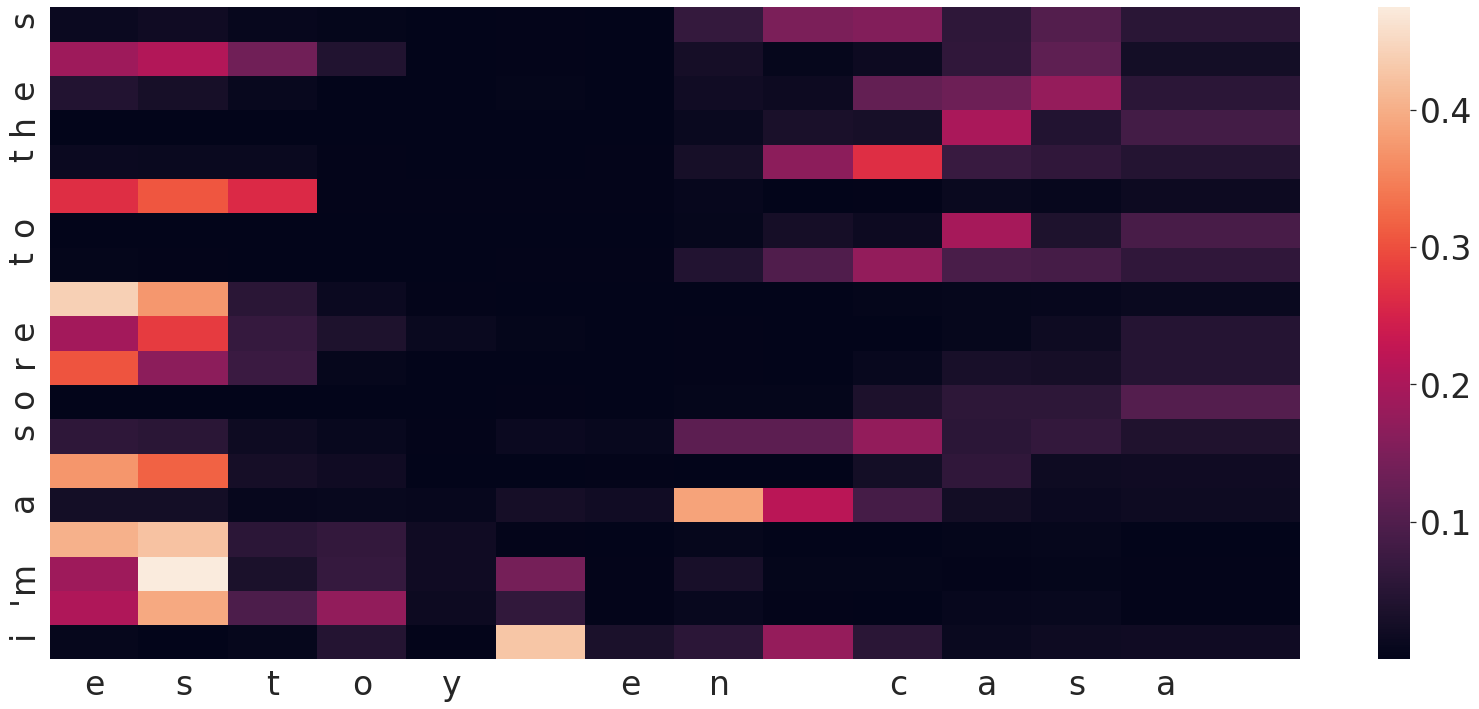

In [ ]:
visualize('estoy en casa')